In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X_train = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_train = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X_train, X_test])

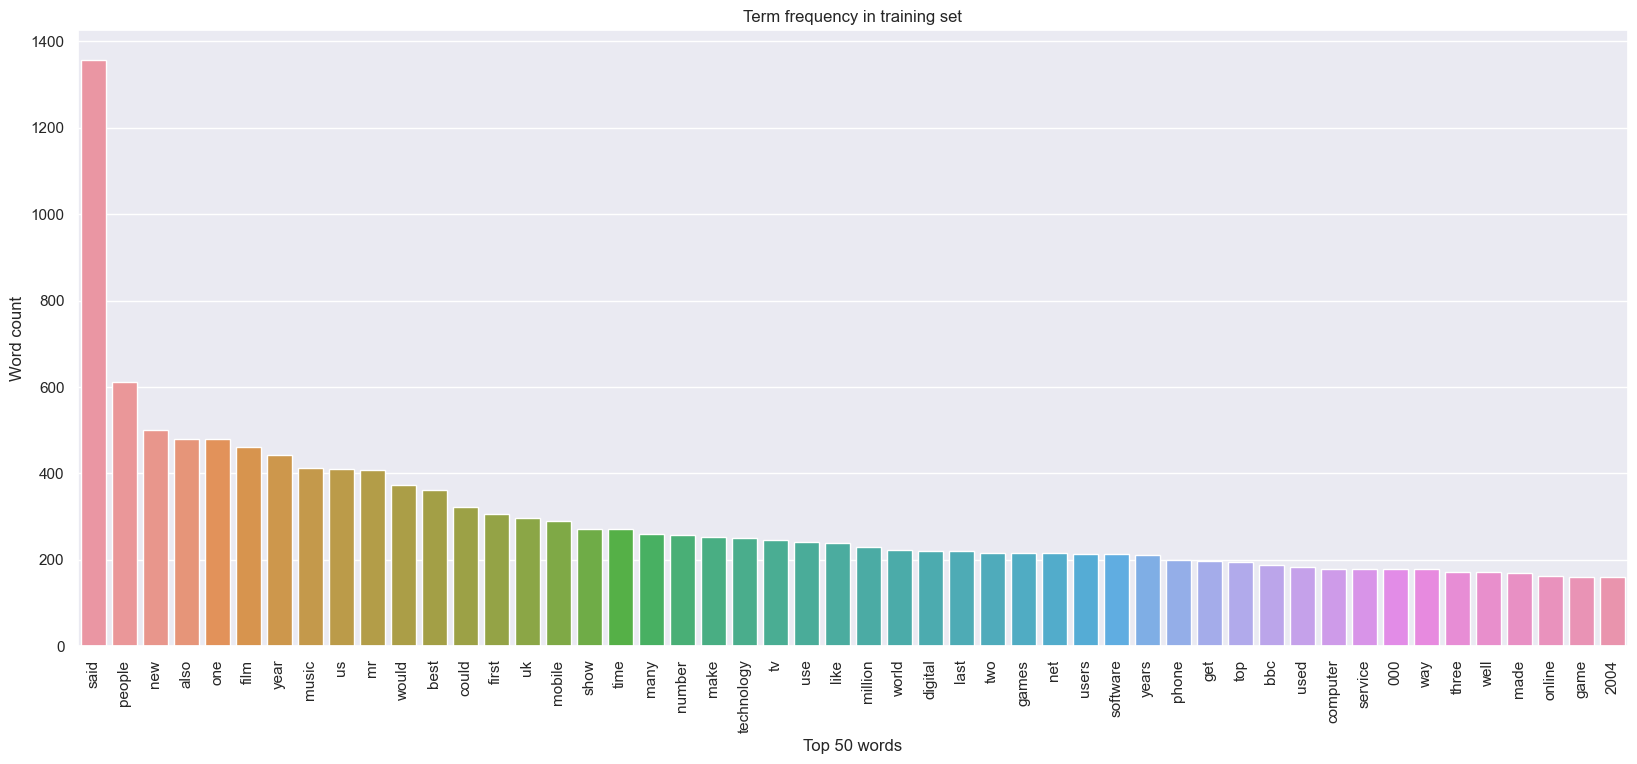

In [3]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
#print(prep_X_count)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

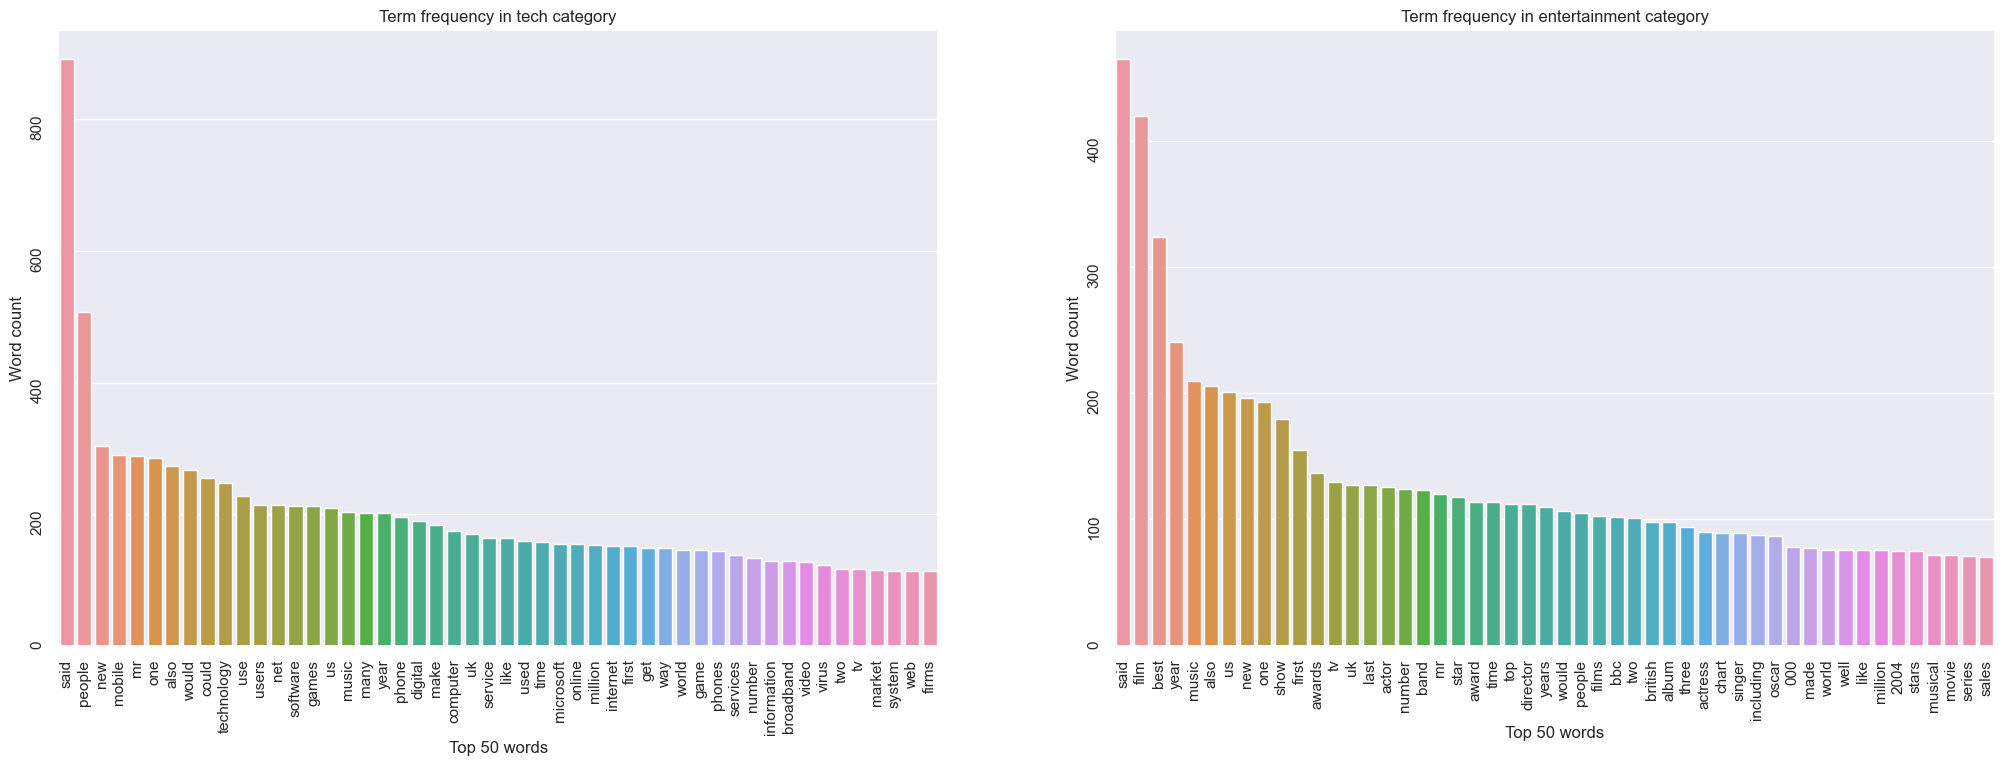

In [4]:
train_label_group = Y_train.groupby(Y_train)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

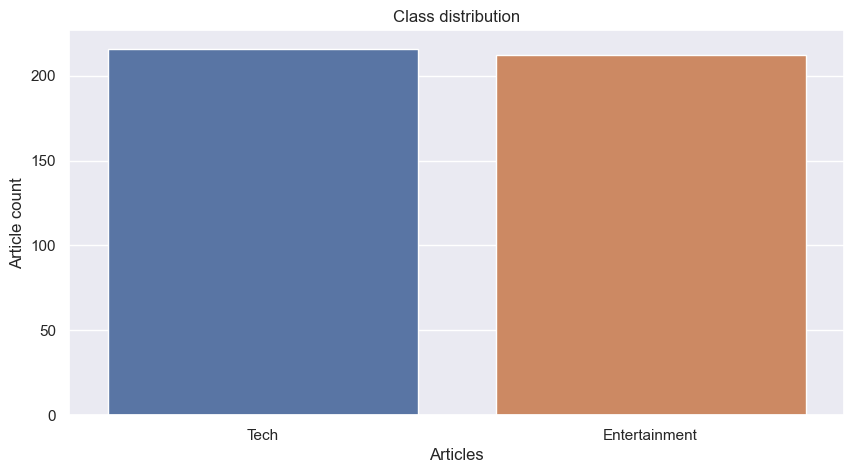

In [5]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [6]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

# encode document
vector = vectorizer.transform(X_test)
prep_X_test = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_test.index)

vector = vectorizer.transform(X_train)
prep_X_train = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_train.index)
print(prep_X_test.shape)
print(prep_X_train.shape)

(106, 13518)
(428, 13518)


# Neural Network

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import warnings

weight_init_range = [0,0.1]

# New MLP class to override init method to initialize weights
class MLPClassifierOverride(MLPClassifier):
    # Overriding _init_coef method
    def _init_coef(self, fan_in, fan_out, dtype):
        # Initialize weights and biases by uniformly sampling from range [0, 0.1]
        coef_init = np.random.uniform(
            weight_init_range[0], weight_init_range[1], (fan_in, fan_out)
        )
        intercept_init = np.random.uniform(weight_init_range[0], weight_init_range[1], fan_out)
        coef_init = coef_init.astype(dtype, copy=False)
        intercept_init = intercept_init.astype(dtype, copy=False)
        return coef_init, intercept_init

In [8]:
warnings.filterwarnings('ignore')

np.random.seed(11)

hid_units = [5,20,40]
results = []
training_losses = []

for hid_unit in hid_units:
    clf = MLPClassifierOverride(hidden_layer_sizes=(hid_unit,), solver='sgd', learning_rate_init=0.01, max_iter=100)
    clf.fit(prep_X_train,Y_train)

    preds = clf.predict(prep_X_test)
    
    score = f1_score(Y_test, preds)

    training_losses.append(clf.loss_curve_)
    results.append([hid_unit, score])

training_losses = np.array(training_losses)
print(results)

[[5, 0.5111111111111111], [20, 0.6021505376344086], [40, 0.7735849056603773]]


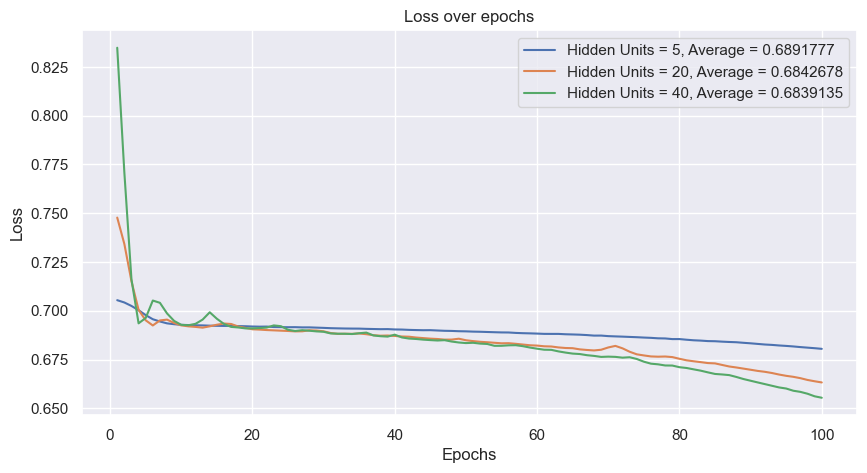

In [9]:
epochs = np.arange(1, 101)
average_losses = np.mean(training_losses, axis=1)
average_losses = np.round(average_losses, decimals= 7)

plot = sns.lineplot(x = epochs, y = training_losses[0], label = str('Hidden Units = 5, Average = ' + str(average_losses[0])))
sns.lineplot(x = epochs, y = training_losses[1], label = str('Hidden Units = 20, Average = ' + str(average_losses[1])))
sns.lineplot(x = epochs, y = training_losses[2], label = str('Hidden Units = 40, Average = ' + str(average_losses[2])))
plot.set_title('Loss over epochs')
plot.set_xlabel('Epochs')
plot.set_ylabel('Loss')
plt.legend()
plt.show()

Given that we're isolating the effects of hidden units on the average loss in training, it looks like theres an inverse relationship between them. As hidden units increase, the average loss decreases. The graph above shows the changes in loss over each epoch of training, and how there's more improvement as we increase hidden units.

In [10]:
# Hyper parameters to tune:
# Shape of hidden layers (), Learning rate, weight initialization, l2 regularization alpha, activation
from sklearn.model_selection import GridSearchCV

shape_of_hidden_layers = [(20,), (40,), (10,10), (20,20), (40, 40), (10,10,10), (20,20,20)]
learning_rate = [1,0.1,0.01,0.001,0.0001]
alpha = [0.1,0.01,0.001,0.0001,0.00001]
activation = ['relu','logistic','tanh']

In [11]:
hid_clf = MLPClassifier()
hid_cv = GridSearchCV(hid_clf, {'hidden_layer_sizes': shape_of_hidden_layers}, scoring='f1', verbose=10)
hid_cv.fit(prep_X_train,Y_train)

ler_clf = MLPClassifier()
ler_cv = GridSearchCV(ler_clf, {'learning_rate_init': learning_rate}, scoring='f1', verbose=10)
ler_cv.fit(prep_X_train,Y_train)

alpha_clf = MLPClassifier()
alpha_cv = GridSearchCV(alpha_clf, {'alpha': alpha}, scoring='f1', verbose=10)
alpha_cv.fit(prep_X_train,Y_train)

activation_clf = MLPClassifier()
activation_cv = GridSearchCV(activation_clf, {'activation': activation}, scoring='f1', verbose=10)
activation_cv.fit(prep_X_train,Y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5; 1/7] START hidden_layer_sizes=(20,)....................................
[CV 1/5; 1/7] END .....hidden_layer_sizes=(20,);, score=1.000 total time=   6.3s
[CV 2/5; 1/7] START hidden_layer_sizes=(20,)....................................
[CV 2/5; 1/7] END .....hidden_layer_sizes=(20,);, score=0.977 total time=   6.2s
[CV 3/5; 1/7] START hidden_layer_sizes=(20,)....................................
[CV 3/5; 1/7] END .....hidden_layer_sizes=(20,);, score=0.977 total time=   5.7s
[CV 4/5; 1/7] START hidden_layer_sizes=(20,)....................................
[CV 4/5; 1/7] END .....hidden_layer_sizes=(20,);, score=0.963 total time=   6.4s
[CV 5/5; 1/7] START hidden_layer_sizes=(20,)....................................
[CV 5/5; 1/7] END .....hidden_layer_sizes=(20,);, score=0.988 total time=   5.9s
[CV 1/5; 2/7] START hidden_layer_sizes=(40,)....................................
[CV 1/5; 2/7] END .....hidden_layer_sizes=(40,);,

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['relu', 'logistic', 'tanh']},
             scoring='f1', verbose=10)

In [60]:
best_hid = hid_cv.best_params_['hidden_layer_sizes']
best_ler = ler_cv.best_params_['learning_rate_init']
best_alpha = alpha_cv.best_params_['alpha']
best_activation = activation_cv.best_params_['activation']

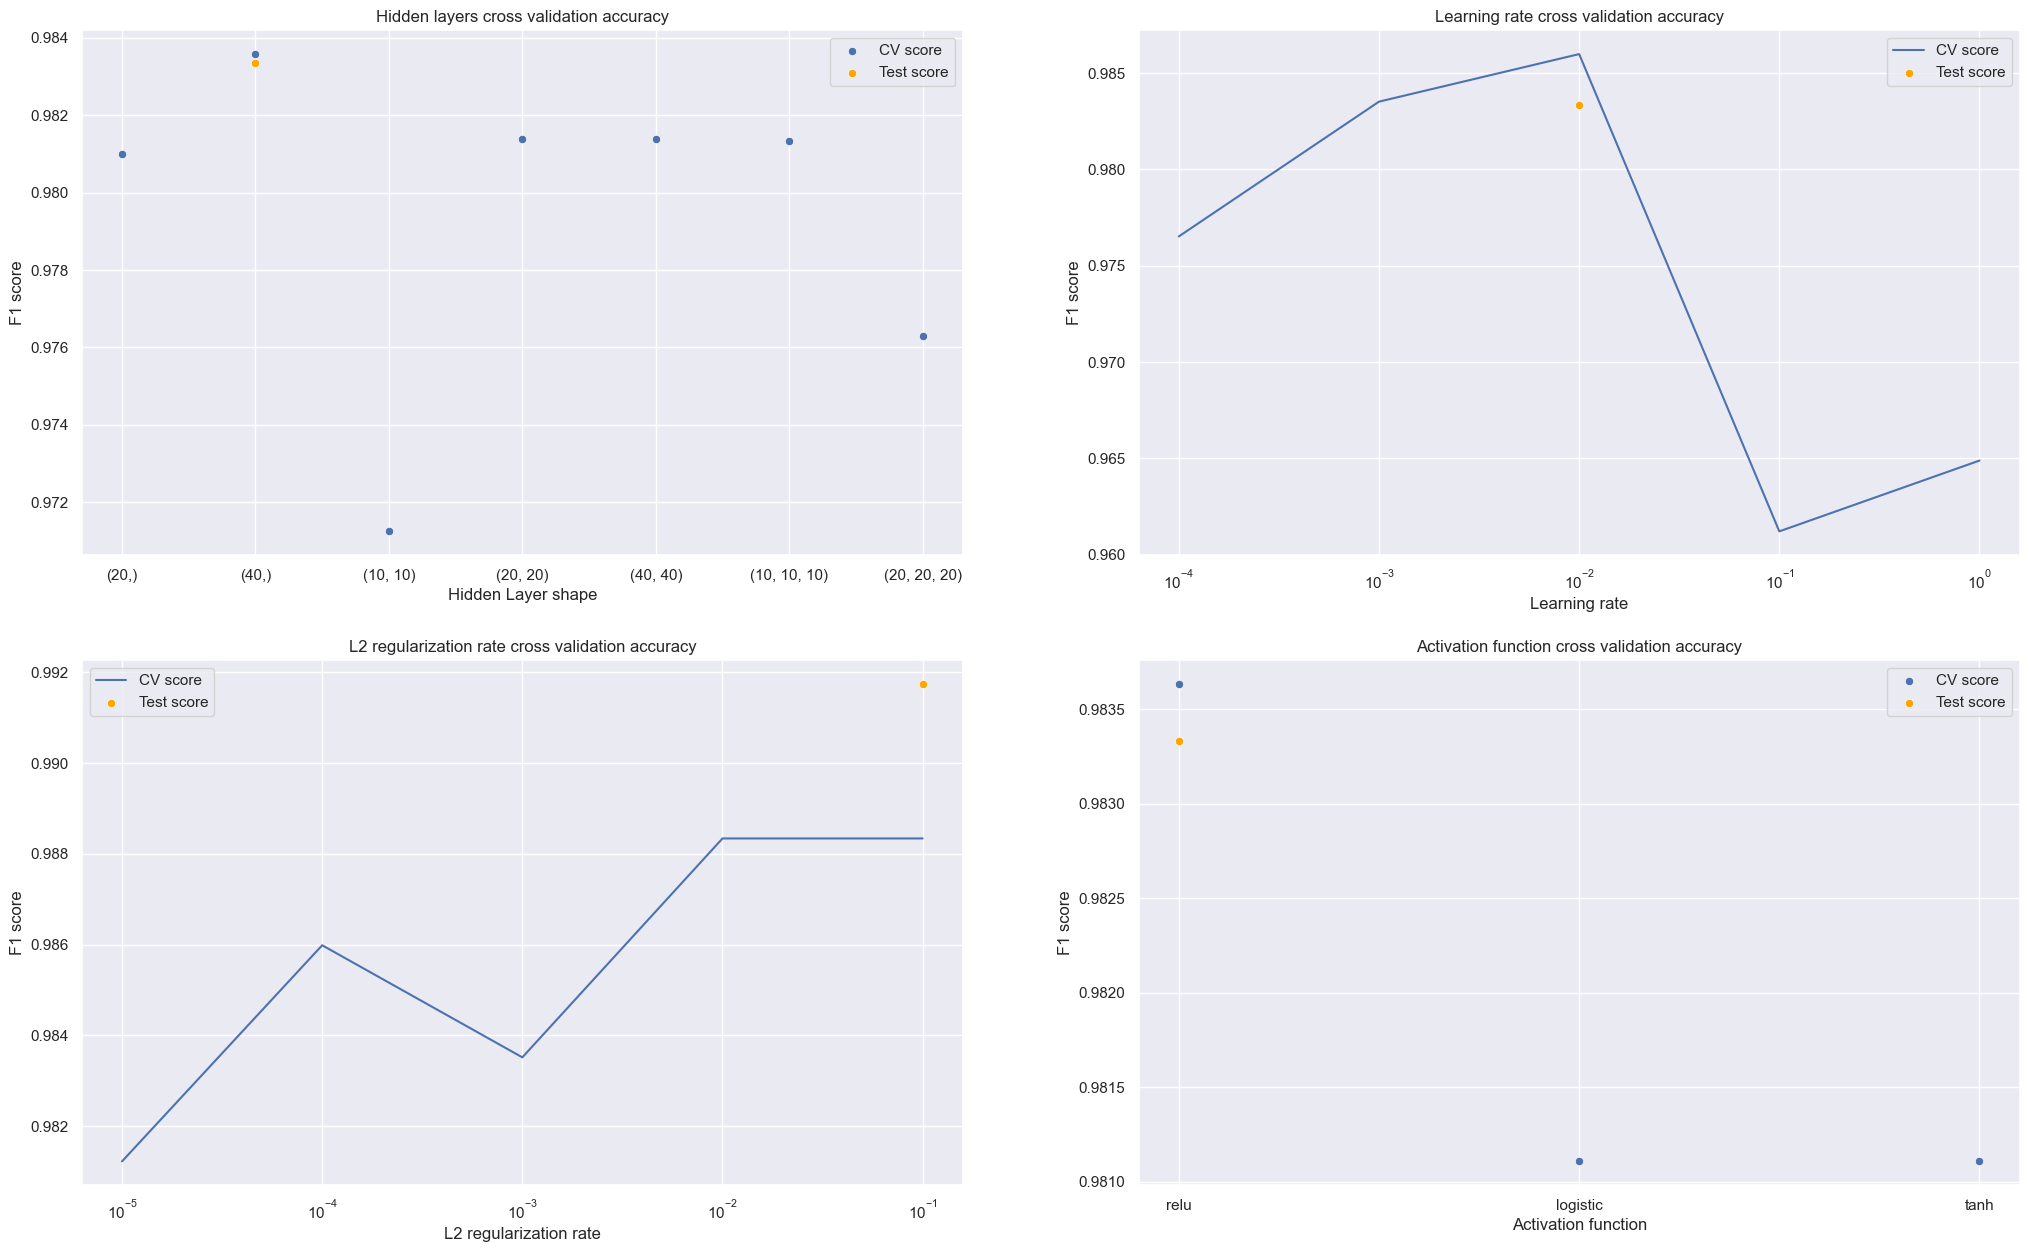

Train set f1-score = 0.9836. Test set f1-score = 0.9833. Hidden layer shape = (40,)
Train set f1-score = 0.9860. Test set f1-score = 0.9833. Learning rate = 0.01
Train set f1-score = 0.9883. Test set f1-score = 0.9917. L2 regularization rate = 0.1
Train set f1-score = 0.9836. Test set f1-score = 0.9833. Activation function = relu


In [71]:
string_hlayers = [str(i) for i in shape_of_hidden_layers]
hid_score = hid_cv.score(prep_X_test, Y_test)
ler_score = ler_cv.score(prep_X_test, Y_test)
alpha_score = alpha_cv.score(prep_X_test, Y_test)
activation_score = activation_cv.score(prep_X_test, Y_test)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(25, 15))
ax[0, 0] = sns.scatterplot(x=string_hlayers, y=hid_cv.cv_results_['mean_test_score'], ax=ax[0,0], label='CV score')
ax[0, 0].set_title('Hidden layers cross validation accuracy')
ax[0, 0].set(xlabel='Hidden Layer shape', ylabel='F1 score')
sns.scatterplot(x=[str(best_hid)], y=hid_score, ax=ax[0, 0], color = 'orange', label='Test score')

ax[0, 1] = sns.lineplot(x=learning_rate, y=ler_cv.cv_results_['mean_test_score'], ax=ax[0,1], label='CV score')
ax[0, 1].set(xscale="log")
ax[0, 1].set_title('Learning rate cross validation accuracy')
ax[0, 1].set(xlabel='Learning rate', ylabel='F1 score')
sns.scatterplot(x=[float(best_ler)], y=ler_score, ax=ax[0, 1], color = 'orange', label='Test score')

ax[1, 0] = sns.lineplot(x=alpha, y=alpha_cv.cv_results_['mean_test_score'], ax=ax[1, 0], label='CV score')
ax[1, 0].set(xscale="log")
ax[1, 0].set_title('L2 regularization rate cross validation accuracy')
ax[1, 0].set(xlabel='L2 regularization rate', ylabel='F1 score')
sns.scatterplot(x=[float(best_alpha)], y=alpha_score, ax=ax[1, 0], color = 'orange', label='Test score')

ax[1, 1] = sns.scatterplot(x=activation, y=activation_cv.cv_results_['mean_test_score'], ax=ax[1, 1], label='CV score')
ax[1, 1].set_title('Activation function cross validation accuracy')
ax[1, 1].set(xlabel='Activation function', ylabel='F1 score')
sns.scatterplot(x=[best_activation], y=activation_score, ax=ax[1, 1], color = 'orange', label='Test score')

plt.show()

print('Train set f1-score = %.4f. Test set f1-score = %.4f. Hidden layer shape = %s' %(hid_cv.best_score_, hid_score, best_hid))
print('Train set f1-score = %.4f. Test set f1-score = %.4f. Learning rate = %s' %(ler_cv.best_score_, ler_score, best_ler))
print('Train set f1-score = %.4f. Test set f1-score = %.4f. L2 regularization rate = %s' %(alpha_cv.best_score_, alpha_score, best_alpha))
print('Train set f1-score = %.4f. Test set f1-score = %.4f. Activation function = %s' %(activation_cv.best_score_, activation_score, best_activation))

Using a 5 fold cross validation on our training dataset, we can see trends in the different hyperparameteres we used. Training a neural network requires time and powerful hardware, hence why we just focused on looking into the effects of individual hyperparameters per cross validation step rather than a combination of multiple hyperparameters. We kept all the other hyperparemeters at default. This does have its caveats as we kept max epochs at default = 200. Some hyperparameters like learning rate and hidden layers might get affected as the model might not converge at an optimal result before stopping. The plot above shows the mean cv score per each hyper parameter training, as well as the test score for the best hyperparameter.

- Increasing both the number of neurons and hidden layers in our model adds complexity to our model. In the first graph, we can see a initial increase in training accuracy but as the layers and number of neurons increase, so does the variance and it overfits. A good cross validation result seems to be one hidden layer with 40 neurons.
- Learning rate determines the steps the model takes during SGD. Scikit learn limits the max epochs to 200 and thus smaller learning might not even converge at all. Theres also a possibility that it might get stuck in a local minima, thus increasing the variance of the result. Larger weights on the other hand might completely miss the minima and underfits the model.
- We've tried exploring the effects of L2 regularization in our model and found that a regularization rate of 0.1 seems to provide us with the best results. This means that the higher the rate, the model gets simpler as to not overfit the data but might cause some bias. 
- Lastly for the activation function, we found that a simple logistic/sigmoid activation function proved to be helpful in our classification. The default scikit NN only has a single layer with 100 neurons that connects to the output, and thus it's not prone to any vanishing or exploding gradients. This makes a sigmoid function more effective in fitting the data due to its non linearity, compared to relu or even another non linear function like tanh.

In [106]:
# Using final hyperparameters used in tuning
np.random.seed(1)

final_clf = MLPClassifier(activation='logistic', alpha=0.1, learning_rate_init=0.01, hidden_layer_sizes=(40,))
final_clf.fit(prep_X_train,Y_train)

pred = final_clf.predict(prep_X_test)
score = f1_score(Y_test, pred)
print(score)

1.0


In [104]:
splits = [0.1, 0.3, 0.5, 0.7, 0.9]
#splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

np.random.seed(1)

T3_train_scores = []
T3_test_scores = []
train_size = prep_X_train.shape[0]

for i in splits:
    split = int(i*train_size)
    T3_X_train = prep_X_train.iloc[:split]
    T3_y_train = Y_train.iloc[:split]

    T3_clf = MLPClassifier(activation='logistic', alpha=0.1, learning_rate_init=0.01, hidden_layer_sizes=(40,))
    T3_clf.fit(T3_X_train, T3_y_train)

    train_pred = T3_clf.predict(T3_X_train)
    train_score = f1_score(T3_y_train, train_pred)

    test_pred = T3_clf.predict(prep_X_test)
    test_score = f1_score(Y_test, test_pred)

    T3_train_scores.append(train_score)
    T3_test_scores.append(test_score)
    
print(T3_test_scores)
print(T3_train_scores)
    

[0.8807339449541284, 0.991869918699187, 0.9752066115702478, 0.9917355371900827, 0.9917355371900827]
[1.0, 1.0, 0.9952153110047847, 1.0, 1.0]


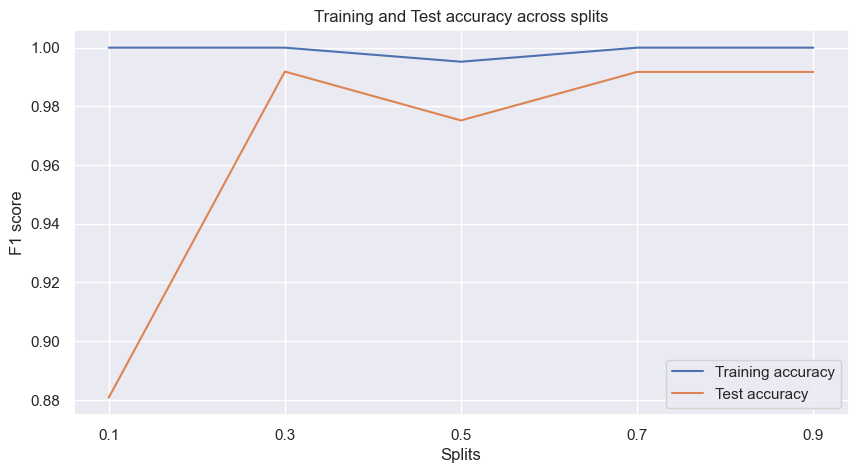

In [109]:
""" fig, ax = plt.subplots(ncols=2, figsize=(25, 15))
ax[0] = sns.lineplot(x=splits, y=T3_train_scores, ax=ax[0])
ax[0].set_title('Training Accuracy across splits')
ax[0].set(xlabel='Splits', ylabel='F1 score')

ax[1] = sns.lineplot(x=splits, y=T3_test_scores, ax=ax[1])
ax[1].set_title('Test Accuracy across splits')
ax[1].set(xlabel='Splits', ylabel='F1 score')
 """

plot = sns.lineplot(x=[str(i) for i in splits], y=T3_train_scores, label = 'Training accuracy')
sns.lineplot(x=[str(i) for i in splits], y=T3_test_scores, label ='Test accuracy')
plot.set_title('Training and Test accuracy across splits')
plot.set(xlabel='Splits', ylabel='F1 score')

plt.show()